In [3]:
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as jr
import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib auto

# GP related libraries
import optax as ox
import gpjax as jgp
import jaxkern as jk
from jaxutils import Dataset

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

In [4]:
f = lambda x: x[1]*jnp.sin(x[0]/10)+jnp.cos(x[3])**3

n = 50
key, subkey = jr.split(key)
x_train = jr.uniform(subkey, shape = (n,3), minval = -10.0, maxval = 10.0)
y_train = f(x_train[0,:]).reshape(-1,1)
for i in range(1,n):
    y_train = jnp.append(y_train,f(x_train[i,:]).reshape(-1,1),axis=0)
    
# key, subkey = jr.split(key)
TEST_N = 100
x_test = jr.uniform(subkey, shape=(TEST_N,3), minval = -10.0, maxval = 10.0  )
y_test = f(x_test[0,:]).reshape(-1,1)
for i in range(1,TEST_N):
    y_test = jnp.append(y_test,f(x_test[i,:]).reshape(-1,1), axis=0)


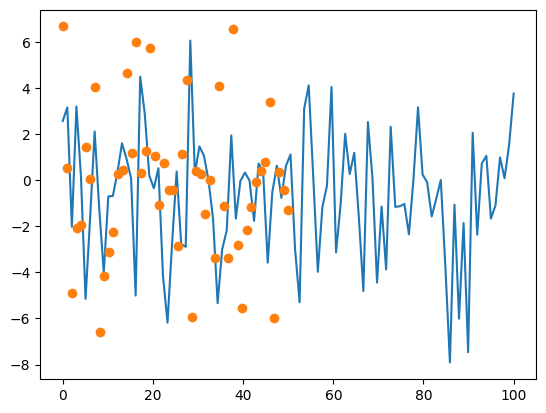

In [5]:
fig, ax = plt.subplots()#(figsize=(10,5))
plt.plot(jnp.linspace(0,TEST_N,TEST_N), y_test, label='latent functions')
plt.plot(jnp.linspace(0,n,n), y_train, "o", label='Observations')
# plt.show()

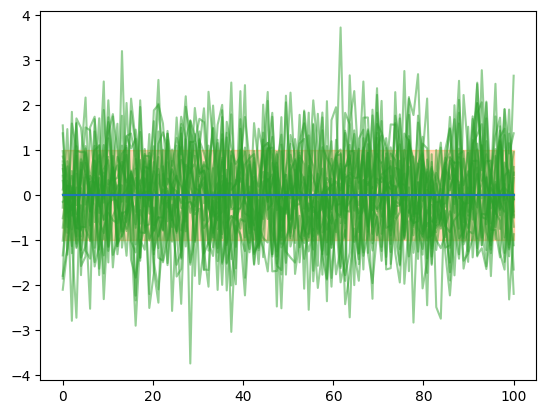

In [6]:
kernel = jk.RBF()
prior = jgp.Prior(kernel = kernel)
parameter_state = jgp.initialise(prior, key)
prior_dist = prior(parameter_state.params)(x_test)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T
fig, ax = plt.subplots()
plt.plot(jnp.linspace(0,TEST_N,TEST_N), samples, color="tab:green", alpha=0.5)
plt.plot(jnp.linspace(0,TEST_N,TEST_N), prior_mean, color="tab:blue")
plt.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
# plt.show()

In [7]:
likelihood = jgp.Gaussian( num_datapoints=n )
posterior = prior * likelihood
parameter_state = jgp.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.5])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [8]:
params, trainable, bijectors = parameter_state.unpack()
print(params)

{'kernel': {'lengthscale': Array([0.5], dtype=float64), 'variance': Array([1.], dtype=float64)}, 'mean_function': {}, 'likelihood': {'obs_noise': Array([1.], dtype=float64)}}


In [9]:
D = Dataset(X=x_train, y=y_train)
# marginak likelihood
negative_mll = jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(191.17352329, dtype=float64)

In [10]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = jgp.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|█| 500/500 [00:00<00:00, 1261.75it/s


In [11]:
learned_params, training_history = inference_state.unpack()
print(learned_params)

{'kernel': {'lengthscale': Array([4.92079206], dtype=float64), 'variance': Array([3.14176471], dtype=float64)}, 'likelihood': {'obs_noise': Array([1.56819506], dtype=float64)}, 'mean_function': {}}


In [47]:
latent_dist = posterior(learned_params, D)(x_test)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()
predictive_mean

Array([ 1.229989  ,  1.62848932, -2.28031208,  4.6253387 , -0.72389352,
       -3.13827824, -0.79590132,  2.7118675 , -1.3118723 , -2.93558909,
        0.20369109, -0.35584123, -0.51896819,  2.47683493,  1.09084316,
       -0.0238965 , -1.83900752,  4.49106435,  2.47154855,  1.2217256 ,
        0.10079226,  1.11781985, -3.02217749, -4.11518148, -3.12924854,
       -0.16999991, -1.90880658, -1.78279616,  3.261627  ,  0.29319531,
        1.95152685,  0.50670358,  0.5073305 , -2.02345644, -3.79831505,
       -2.8650888 , -2.42301059,  1.62748632, -1.2633332 , -0.54845958,
        1.17883905,  0.79854306, -1.35094428,  0.76509737,  0.52800895,
       -2.29846784, -0.94824392,  0.12851119,  0.12655012,  1.75254387,
        0.09175006, -3.24781316, -2.57360144,  1.6315705 ,  1.55270583,
       -0.3593779 , -1.80733533, -1.12892082, -0.6688976 ,  3.9001691 ,
       -4.47958798, -1.5830165 ,  2.58788814,  0.61814492,  0.34197599,
        0.14789657, -2.82384405,  1.99045311,  0.01432778, -2.26

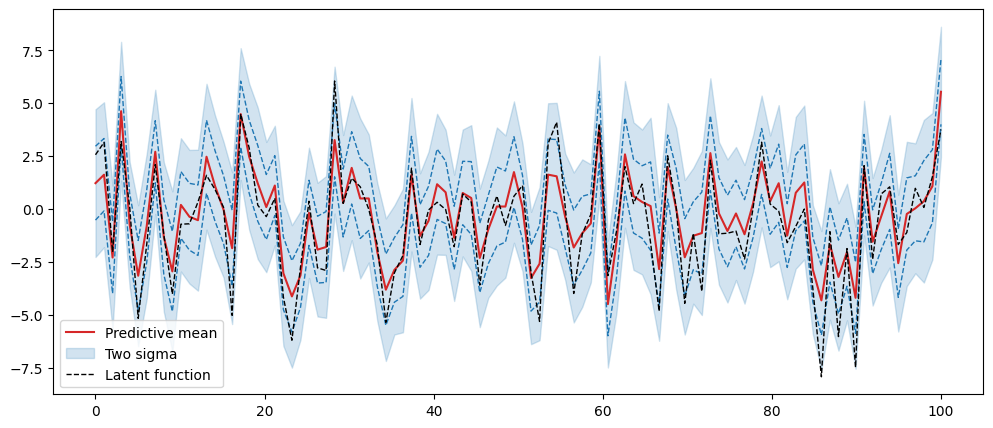

In [43]:
fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(jnp.linspace(0,n,n), y_train, "o", label="Observations", color="tab:red")
ax.plot(jnp.linspace(0,TEST_N,TEST_N), predictive_mean, label="Predictive mean", color="tab:red")
ax.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    jnp.linspace(0,TEST_N,TEST_N), y_test, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

In [46]:
latent_dist = posterior(learned_params, D)(3*x_test)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()
predictive_mean

Array([ 3.98473012e-03,  4.22271115e-04, -1.64758978e-01,  2.79686473e-02,
       -8.80849043e-03, -6.03681850e-03, -7.92337593e-01,  2.72202672e-02,
       -2.49340852e+00, -6.31418605e-06,  2.41284556e-03, -2.54288488e-04,
       -1.50856285e-03,  3.74491857e-04,  9.02542231e-02, -6.03882830e-02,
       -1.07542008e-07,  4.61033554e-04,  4.25518446e-03,  1.22491673e-04,
       -1.54067878e-02, -1.90558928e-02, -5.05605747e-05, -1.89318550e-07,
       -2.00305112e-02, -1.30447035e-01, -5.49915469e-05, -1.64826135e-06,
        6.58163053e-07,  1.69975784e+00,  7.89345630e-03,  3.81455516e-02,
        1.19794407e-01, -1.87581338e-01, -1.09178189e-06, -5.35330801e-01,
       -4.19718881e-02,  9.65334383e-05, -7.83275112e-02, -3.88236697e-03,
        3.78679156e-04,  6.52350190e-01, -2.38767765e+00,  8.30983992e-01,
        4.16290625e-03, -2.10922892e-03, -5.08022942e-02,  5.47514129e-06,
       -2.73250604e-05,  1.47725763e+00, -9.73293628e-04, -1.55338933e-02,
       -8.49622518e-08,  

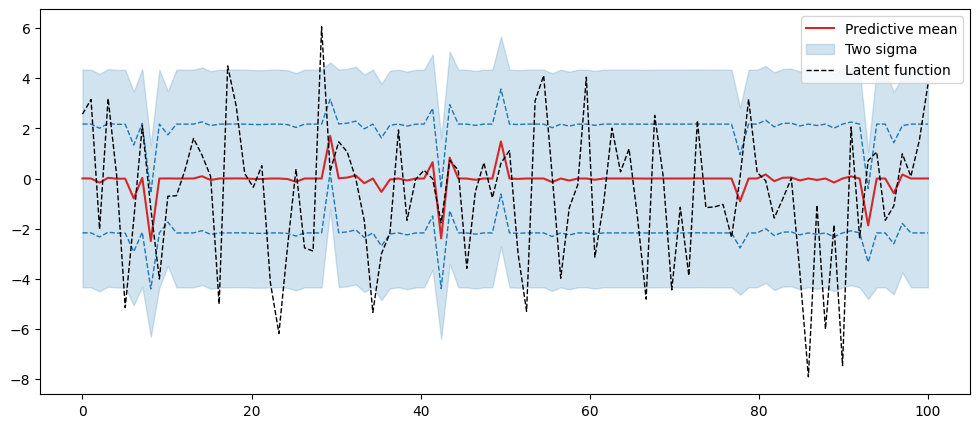

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(jnp.linspace(0,n,n), y_train, "o", label="Observations", color="tab:red")
ax.plot(jnp.linspace(0,TEST_N,TEST_N), predictive_mean, label="Predictive mean", color="tab:red")
ax.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    jnp.linspace(0,TEST_N,TEST_N), y_test, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

In [50]:
def pred_mean(posterior, likelihood, learned_params, D, x_test):
    f_latent_dist = posterior(learned_params, D)(x_test)
    f_predictive_dist = likelihood(learned_params, f_latent_dist)
    f_predictive_mean = f_predictive_dist.mean()
    return f_predictive_mean

In [51]:
pred_mean(posterior, likelihood, learned_params, D, 3*x_test)

Array([ 3.98473012e-03,  4.22271115e-04, -1.64758978e-01,  2.79686473e-02,
       -8.80849043e-03, -6.03681850e-03, -7.92337593e-01,  2.72202672e-02,
       -2.49340852e+00, -6.31418605e-06,  2.41284556e-03, -2.54288488e-04,
       -1.50856285e-03,  3.74491857e-04,  9.02542231e-02, -6.03882830e-02,
       -1.07542008e-07,  4.61033554e-04,  4.25518446e-03,  1.22491673e-04,
       -1.54067878e-02, -1.90558928e-02, -5.05605747e-05, -1.89318550e-07,
       -2.00305112e-02, -1.30447035e-01, -5.49915469e-05, -1.64826135e-06,
        6.58163053e-07,  1.69975784e+00,  7.89345630e-03,  3.81455516e-02,
        1.19794407e-01, -1.87581338e-01, -1.09178189e-06, -5.35330801e-01,
       -4.19718881e-02,  9.65334383e-05, -7.83275112e-02, -3.88236697e-03,
        3.78679156e-04,  6.52350190e-01, -2.38767765e+00,  8.30983992e-01,
        4.16290625e-03, -2.10922892e-03, -5.08022942e-02,  5.47514129e-06,
       -2.73250604e-05,  1.47725763e+00, -9.73293628e-04, -1.55338933e-02,
       -8.49622518e-08,  

In [52]:
pred_mean_lambda = lambda x : pred_mean(posterior, likelihood, learned_params, D, x)

In [53]:
%timeit pred_mean_lambda(x_test)

29.3 ms ± 885 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
pred_mean_lambda_jit = jit(pred_mean_lambda)

In [57]:
%timeit pred_mean_lambda_jit(x_test)

196 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
pred_mean_lambda_jit(x_test*3)

Array([ 3.98473012e-03,  4.22271115e-04, -1.64758978e-01,  2.79686473e-02,
       -8.80849043e-03, -6.03681850e-03, -7.92337593e-01,  2.72202672e-02,
       -2.49340852e+00, -6.31418605e-06,  2.41284556e-03, -2.54288488e-04,
       -1.50856285e-03,  3.74491857e-04,  9.02542231e-02, -6.03882830e-02,
       -1.07542008e-07,  4.61033554e-04,  4.25518446e-03,  1.22491673e-04,
       -1.54067878e-02, -1.90558928e-02, -5.05605747e-05, -1.89318550e-07,
       -2.00305112e-02, -1.30447035e-01, -5.49915469e-05, -1.64826135e-06,
        6.58163053e-07,  1.69975784e+00,  7.89345630e-03,  3.81455516e-02,
        1.19794407e-01, -1.87581338e-01, -1.09178189e-06, -5.35330801e-01,
       -4.19718881e-02,  9.65334383e-05, -7.83275112e-02, -3.88236697e-03,
        3.78679156e-04,  6.52350190e-01, -2.38767765e+00,  8.30983992e-01,
        4.16290625e-03, -2.10922892e-03, -5.08022942e-02,  5.47514129e-06,
       -2.73250604e-05,  1.47725763e+00, -9.73293628e-04, -1.55338933e-02,
       -8.49622518e-08,  